In [18]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from IPython import embed
from astropy.cosmology import Planck15 as cosmo
import camb
import pickle

from astropy import constants
import scipy.constants as cst
from scipy.io import readsav
from scipy.interpolate import interp2d, interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from astropy import wcs
import powspec
from astropy.table import Table
import os
import vaex as vx
import time
from scipy.optimize import curve_fit
from functools import partial
from multiprocessing import Pool, cpu_count
from colossus.lss import bias
from colossus.cosmology import cosmology
Cosmo = cosmology.setCosmology('planck15')
h = Cosmo.H0/100
#from astropy.cosmology import z_at_value
import datetime
from astropy.stats import gaussian_fwhm_to_sigma
import astropy.convolution as conv
from matplotlib.colors import LogNorm
import time
from set_k import * 
from scientific_notation import * 
from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler
from scipy.interpolate import interp1d
#-------------------------------------------------

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.markers as mmarkers

In [19]:
def get_2d_pk_matter(z):
    
    pars = camb.read_ini("planck2018.ini")
    pars.set_matter_power(redshifts=z, kmax=100)
    results = camb.get_results(pars)    
    #Linear spectra
    #_,_,pk_matter = results.get_linear_matter_power_spectrum(hubble_units=False, k_hunit= False)
    K,_,pk_matter_nonlin = results.get_linear_matter_power_spectrum(hubble_units=False, k_hunit= False)
    '''
    Dc = cosmo.comoving_distance(z) / u.rad
    delta_Dc = ( (cst.c*1e-3*u.km/u.s) * (1+z) * dnu*u.GHz / cosmo.H(z) / nu_obs.to(u.GHz)) # == cosmo.comoving_distance(z+dzmax) - cosmo.comoving_distance(z-dzmin) checked
    angular_k = (Dc * k/u.Mpc).to(u.arcmin**-1)/2/np.pi #(Dc.value * k_per_mpc.value) * (np.pi/180/60) * (u.arcmin**-1) /2/np.pi checked
    p2d = pk_matter_nonlin[0] / (Dc**2*delta_Dc).value
    '''
    return K, pk_matter_nonlin

In [20]:
field_size_list = np.logspace(np.log10(0.01), np.log10(1.5), 13) ##!!
#------
Mstarlim_bin = np.logspace(9, 12, 20) ##!!
#------
dz_list = (0.01, 0.05, 0.1, 0.2, 0.3)
dz = 0.2
z_list = np.arange(0.5,3.5, dz/2)
# Calculate the edges
diffs = np.diff(z_list) / 2.0
bin_edges = np.zeros(len(z_list) + 1)
bin_edges[1:-1] = z_list[:-1] + diffs
bin_edges[0] = z_list[0] - diffs[0]
bin_edges[-1] = z_list[-1] + diffs[-1]
#------
freq_CII = 1900.53690000 * u.GHz
nu_obs = freq_CII / (1+z_list)
Dnu = dz * nu_obs / (1+z_list)
#------
K, P_of_K_matter_list =  get_2d_pk_matter(z_list)
Kbins = np.logspace(np.log10(K.min()),np.log10(K.max()), 30)
#plt.loglog(K, np.ones(len(K)), 'or', markersize=1)
#plt.loglog(Kbins, np.ones(len(Kbins)), 'ob', markersize=3)


Note: redshifts have been re-sorted (earliest first)


In [39]:
#With SIDES Bolshoi, for rapid tests. 
dirpath="/home/mvancuyck/"
cat = Table.read(dirpath+'pySIDES_from_original.fits')
cat = cat.to_pandas()
simu='pySIDES_from_bolshoi'; fs=2

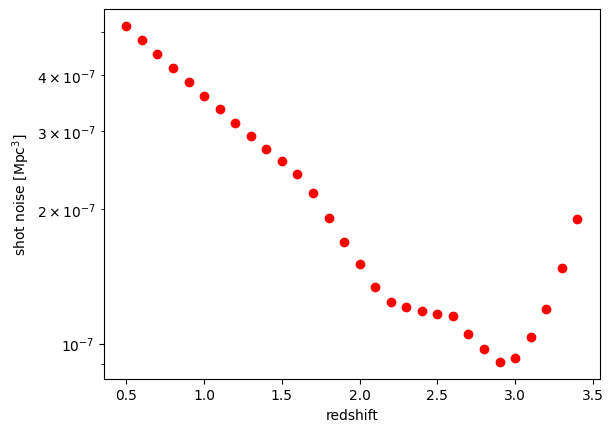

In [42]:
for i, (z, P_of_K) in enumerate(zip(z_list[::-1], P_of_K_matter_list)): 
        cat_galaxies = cat.loc[ (cat["Mstar"] >= 1e10) & (cat["redshift"] >= bin_edges[i]) & (cat["redshift"] < bin_edges[i+1]) ]
        shot_noise = 1 / (len(cat_galaxies) / (field_size_list[-1]*u.deg**2).to(u.sr)).value
        plt.plot(z, shot_noise, 'or')
plt.xlabel('redshift')
plt.ylabel('shot noise [$\\rm Mpc^3$]')
plt.yscale('log')

/tmp/ipykernel_95820/3303902564.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  shot_noise = 1 / (len(cat_galaxies) / (field_size_list[-1]*u.deg**2).to(u.sr)).value


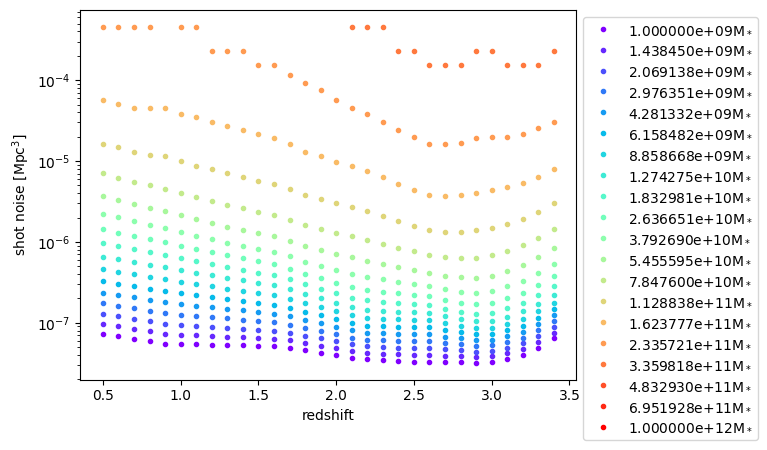

In [43]:
for mlim, c in zip(Mstarlim_bin,cm.rainbow(np.linspace(0,1,len(Mstarlim_bin)))):
        for i, (z, P_of_K) in enumerate(zip(z_list[::-1], P_of_K_matter_list)): 
                cat_galaxies = cat.loc[ (cat["Mstar"] >= mlim) & (cat["redshift"] >= bin_edges[i]) & (cat["redshift"] < bin_edges[i+1]) ]
                shot_noise = 1 / (len(cat_galaxies) / (field_size_list[-1]*u.deg**2).to(u.sr)).value
                if(i==0): plt.plot(z, shot_noise, 'o', color=c, markersize=3, label=f'{mlim:2e}'+'$\\rm M_*$')
                else:     plt.plot(z, shot_noise, 'o', color=c, markersize=3)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('redshift')
plt.ylabel('shot noise [$\\rm Mpc^3$]')
plt.yscale('log')

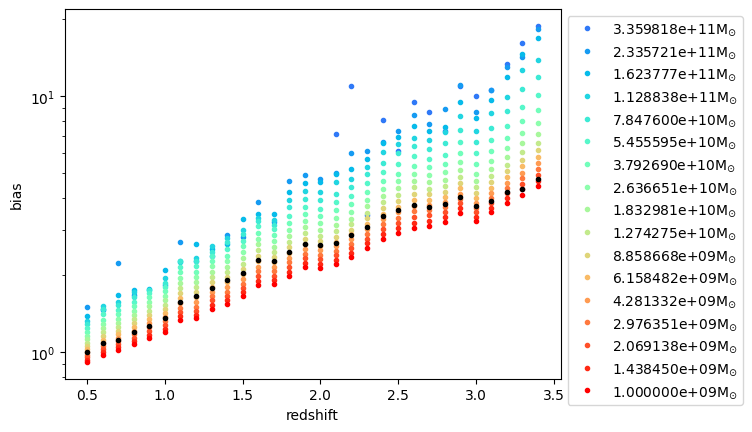

In [58]:
for i, (z, P_of_K) in enumerate(zip(z_list[::-1], P_of_K_matter_list)): 
        cat_galaxies = cat.loc[ (cat["redshift"] >= bin_edges[i]) & (cat["redshift"] < bin_edges[i+1]) ]
        if(len(cat_galaxies)==0): continue
        b = bias.haloBias(cat_galaxies["Mhalo"]/h, model = 'tinker10', z=z, mdef = '200m')
        b_CII = ( np.sum(b * cat_galaxies[f'ICII_de_Looze']) / np.sum(cat_galaxies[f'ICII_de_Looze']) )
        shot_noise = 1 / (len(cat_galaxies) / (field_size_list[-1]*u.deg**2).to(u.sr)).value

        for j, (mlim, c) in enumerate(zip(Mstarlim_bin[::-1],cm.rainbow(np.linspace(0,1,len(Mstarlim_bin))))):

                cat_galaxies_w = cat_galaxies.loc[(cat_galaxies["Mstar"] >= mlim)]
                if(len(cat_galaxies_w)==0): continue
                b = bias.haloBias(cat_galaxies_w["Mhalo"]/h, model = 'tinker10', z=z, mdef = '200m')
                if(i==0): plt.plot(z, b.mean(), 'o', color=c, markersize=3, label=f'{mlim:2e}'+'$\\rm M_{\\odot}$')
                else:     plt.plot(z, b.mean(), 'o', color=c, markersize=3)
        plt.plot(z, b_CII.mean(), 'o', color='k', markersize=3,)

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('redshift')
plt.ylabel('bias')
plt.yscale('log')

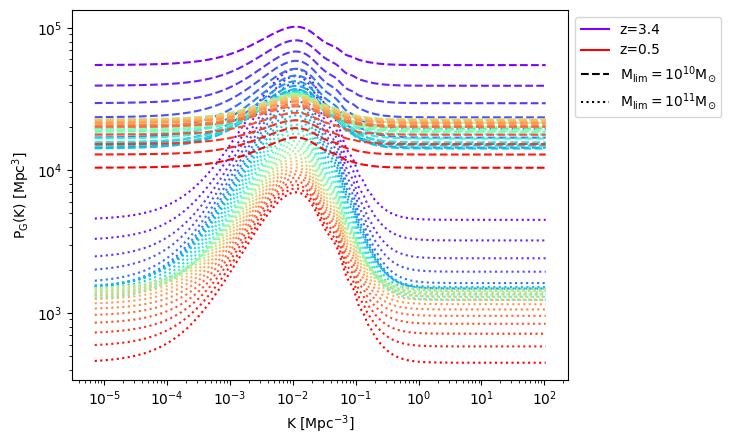

In [8]:
patchs=[]
for i, (z, P_of_K,c) in enumerate(zip(z_list[::-1], P_of_K_matter_list, cm.rainbow(np.linspace(0,1,len(z_list[::-1]))))): 

                Dc_min = cosmo.comoving_distance(bin_edges[i])
                Dc_max = cosmo.comoving_distance(bin_edges[i+1])
                Dc =  cosmo.comoving_distance(z)/u.rad
                delta_Dc = ( (cst.c*1e-3*u.km/u.s) * (1+z) * Dnu[i] / cosmo.H(z) / nu_obs[i])
                pk_3d_to_2d = 1/(Dc**2*delta_Dc)
                k_3d_to_2d  = Dc/2/np.pi

                cat_galaxies = cat.loc[cat["Mstar"] >= 1e10]
                cat_galaxies = cat_galaxies.loc[cat["redshift"] >= bin_edges[i]]
                cat_galaxies = cat_galaxies.loc[cat["redshift"] < bin_edges[i+1]]
                shot_noise = 1 / (len(cat_galaxies) / (field_size_list[-1]*u.deg**2).to(u.sr)).value


                plt.loglog(K, P_of_K + (shot_noise / pk_3d_to_2d).value, ls=':', color=c)

                cat_galaxies = cat.loc[cat["Mstar"] >= 1e11]
                cat_galaxies = cat_galaxies.loc[cat["redshift"] >= bin_edges[i]]
                cat_galaxies = cat_galaxies.loc[cat["redshift"] < bin_edges[i+1]]
                shot_noise = 1 / (len(cat_galaxies) / (field_size_list[-1]*u.deg**2).to(u.sr)).value

                plt.loglog(K, P_of_K + (shot_noise / pk_3d_to_2d).value, ls='--', color=c)
                


                if(i==0): patch = mlines.Line2D([], [], color=c, linestyle="solid", label=f'z={np.round(z,1)}' ); patchs.append(patch);
                if(i==len(z_list)-1): patch = mlines.Line2D([], [], color=c, linestyle="solid", label=f'z={z}' ); patchs.append(patch);
patch = mlines.Line2D([], [], color='k', linestyle="--", label='$ \\rm M_{lim}=\\rm 10^{10} M_{\\odot}$'); patchs.append(patch);
patch = mlines.Line2D([], [], color='k', linestyle=":", label='$ \\rm M_{lim}=\\rm 10^{11} M_{\\odot}$'); patchs.append(patch);


plt.legend(handles=patchs, bbox_to_anchor=(1,1))
plt.xlabel('K [$\\rm Mpc^{-3}$]')
plt.ylabel('$\\rm P_G$(K) [$\\rm Mpc^3$]')
plt.yscale('log')

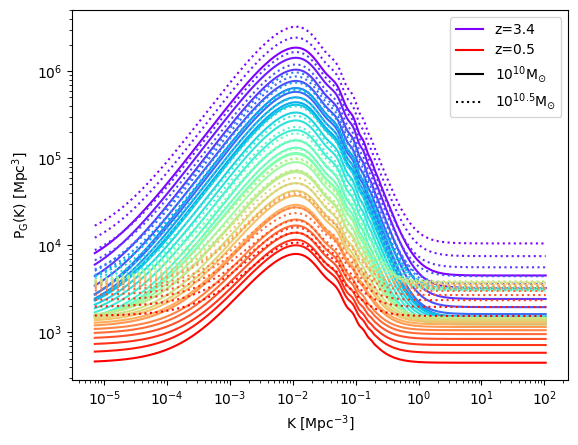

In [63]:
patchs=[]
for i, (z, P_of_K,c) in enumerate(zip(z_list[::-1], P_of_K_matter_list, cm.rainbow(np.linspace(0,1,len(z_list[::-1]))))): 

                Dc_min = cosmo.comoving_distance(bin_edges[i])
                Dc_max = cosmo.comoving_distance(bin_edges[i+1])
                Dc =  cosmo.comoving_distance(z)/u.rad
                delta_Dc = ( (cst.c*1e-3*u.km/u.s) * (1+z) * Dnu[i] / cosmo.H(z) / nu_obs[i])
                pk_3d_to_2d = 1/(Dc**2*delta_Dc)
                k_3d_to_2d  = Dc/2/np.pi

                cat_galaxies = cat.loc[ (cat["Mstar"] >= 1e10) & (cat["redshift"] >= bin_edges[i]) & (cat["redshift"] < bin_edges[i+1]) ]
                shot_noise = 1 / (len(cat_galaxies) / (field_size_list[-1]*u.deg**2).to(u.sr)).value
                #plt.loglog(K, P_of_K + (shot_noise / pk_3d_to_2d).value, ls=':', color=c)
                b = bias.haloBias(cat_galaxies["Mhalo"]/h, model = 'tinker10', z=z, mdef = '200m')
                plt.loglog(K, P_of_K*(b.mean())**2 + (shot_noise / pk_3d_to_2d).value, color=c)


                cat_galaxies = cat.loc[ (cat["Mstar"] >= 10**(10.5)) & (cat["redshift"] >= bin_edges[i]) & (cat["redshift"] < bin_edges[i+1]) ]
                shot_noise = 1 / (len(cat_galaxies) / (field_size_list[-1]*u.deg**2).to(u.sr)).value
                #plt.loglog(K, P_of_K + (shot_noise / pk_3d_to_2d).value, ls=':', color=c)
                b = bias.haloBias(cat_galaxies["Mhalo"]/h, model = 'tinker10', z=z, mdef = '200m')
                plt.loglog(K, P_of_K*(b.mean())**2 + (shot_noise / pk_3d_to_2d).value, color=c, ls=':')

                if(i==0): patch = mlines.Line2D([], [], color=c, linestyle="solid", label=f'z={np.round(z,1)}' ); patchs.append(patch);
                if(i==len(z_list)-1): patch = mlines.Line2D([], [], color=c, linestyle="solid", label=f'z={z}' ); patchs.append(patch);
patch = mlines.Line2D([], [], color='k', linestyle="solid", label='$\\rm 10^{10} M_{\\odot}$' ); patchs.append(patch);
patch = mlines.Line2D([], [], color='k', linestyle=":", label='$\\rm 10^{10.5} M_{\\odot}$' ); patchs.append(patch);


plt.legend(handles=patchs, bbox_to_anchor=(1,1))
plt.xlabel('K [$\\rm Mpc^{-3}$]')
plt.ylabel('$\\rm P_G$(K) [$\\rm Mpc^3$]')
plt.yscale('log')

/tmp/ipykernel_95820/3989582002.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  sn_list.append( 1 / (len(cat_subfield_z) / (tile_size*u.deg**2).to(u.sr)).value / pk_3d_to_2d.value )
/home/mvancuyck/anaconda3/envs/camb/lib/python3.9/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


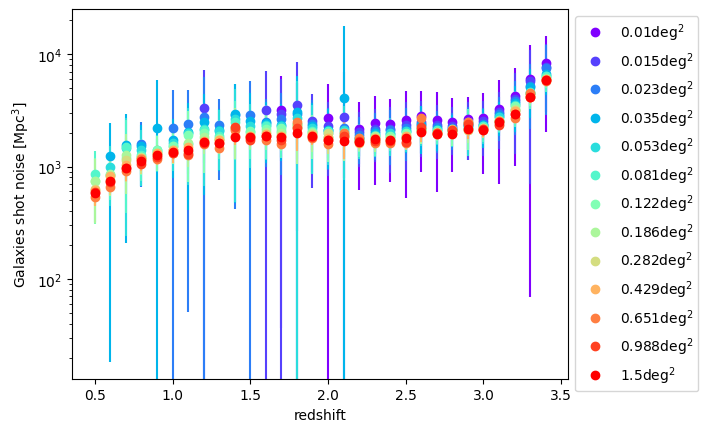

In [64]:
patchs = []
for tile_size, c in zip(field_size_list, cm.rainbow(np.linspace(0,1,len(field_size_list)))):
    if(fs<tile_size): continue
    patch = mlines.Line2D([], [], color=c, linestyle="None", marker='o', label=str(np.round(tile_size,3))+'$\\rm deg^2$'); patchs.append(patch);

    ragrid=np.arange(cat['ra'].min(),cat['ra'].max(),np.sqrt(tile_size))
    decgrid=np.arange(cat['dec'].min(),cat['dec'].max(),np.sqrt(tile_size))
    grid=np.array(np.meshgrid(ragrid,decgrid))

    ra_index = np.arange(0,len(ragrid)-1,1)
    dec_index = np.arange(0,len(decgrid)-1,1)
    ra_grid, dec_grid = np.meshgrid(ra_index, dec_index)
    # Flatten the grids and stack them into a single array
    coords = np.stack((ra_grid.flatten(), dec_grid.flatten()), axis=1)

    for i, (z, P_of_K,C) in enumerate(zip(z_list[::-1], P_of_K_matter_list, cm.rainbow(np.linspace(0,1,len(z_list[::-1]))))): 
        sn_list = []

        cat_subfield = cat.loc[ (cat["redshift"] >= bin_edges[i]) & (cat["redshift"] < bin_edges[i+1]) & (cat["Mstar"] >= 1e10) ]

        for l, (ira, idec) in enumerate(coords):
            if l > 200: break 
            cat_subfield_z = cat_subfield.loc[(cat_subfield['ra']>=grid[0,idec,ira])&(cat_subfield['ra']<grid[0,idec,ira+1])&(cat_subfield['dec']>=grid[1,idec,ira])&(cat_subfield['dec']<grid[1,idec+1,ira])] 

            Dc_min = cosmo.comoving_distance(bin_edges[i])
            Dc_max = cosmo.comoving_distance(bin_edges[i+1])
            Dc =  cosmo.comoving_distance(z)/u.rad
            delta_Dc = ( (cst.c*1e-3*u.km/u.s) * (1+z) * Dnu[i] / cosmo.H(z) / nu_obs[i])
            pk_3d_to_2d = 1/(Dc**2*delta_Dc)
            k_3d_to_2d  = Dc/2/np.pi

            sn_list.append( 1 / (len(cat_subfield_z) / (tile_size*u.deg**2).to(u.sr)).value / pk_3d_to_2d.value )
        
        plt.errorbar(z, np.asarray(sn_list).mean(), yerr=np.asarray(sn_list).std(), fmt='o', color=c, ecolor=c)
plt.yscale('log')
plt.ylabel('Galaxies shot noise [$\\rm Mpc^3]$')
plt.xlabel('redshift')
plt.legend(handles=patchs, bbox_to_anchor=(1,1))
    

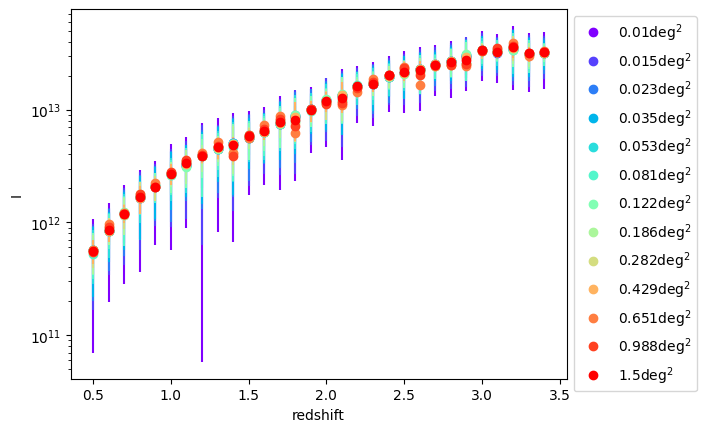

In [68]:
patchs = []
for tile_size, c in zip(field_size_list, cm.rainbow(np.linspace(0,1,len(field_size_list)))):
    if(fs<tile_size): continue
    patch = mlines.Line2D([], [], color=c, linestyle="None", marker='o', label=str(np.round(tile_size,3))+'$\\rm deg^2$'); patchs.append(patch);

    ragrid=np.arange(cat['ra'].min(),cat['ra'].max(),np.sqrt(tile_size))
    decgrid=np.arange(cat['dec'].min(),cat['dec'].max(),np.sqrt(tile_size))
    grid=np.array(np.meshgrid(ragrid,decgrid))

    ra_index = np.arange(0,len(ragrid)-1,1)
    dec_index = np.arange(0,len(decgrid)-1,1)
    ra_grid, dec_grid = np.meshgrid(ra_index, dec_index)
    # Flatten the grids and stack them into a single array
    coords = np.stack((ra_grid.flatten(), dec_grid.flatten()), axis=1)

    for i, (z, P_of_K,C) in enumerate(zip(z_list[::-1], P_of_K_matter_list, cm.rainbow(np.linspace(0,1,len(z_list[::-1]))))): 
        I_list = []

        cat_subfield = cat.loc[ (cat["redshift"] >= bin_edges[i]) & (cat["redshift"] < bin_edges[i+1]) ]

        for l, (ira, idec) in enumerate(coords):
            if l > 200: break 
            cat_subfield_z = cat_subfield.loc[(cat_subfield['ra']>=grid[0,idec,ira])&(cat_subfield['ra']<grid[0,idec,ira+1])&(cat_subfield['dec']>=grid[1,idec,ira])&(cat_subfield['dec']<grid[1,idec+1,ira])] 

            Dc_min = cosmo.comoving_distance(bin_edges[i])
            Dc_max = cosmo.comoving_distance(bin_edges[i+1])
            Dc =  cosmo.comoving_distance(z)/u.rad
            delta_Dc = ( (cst.c*1e-3*u.km/u.s) * (1+z) * Dnu[i] / cosmo.H(z) / nu_obs[i])
            pk_3d_to_2d = 1/(Dc**2*delta_Dc)
            k_3d_to_2d  = Dc/2/np.pi

            freq_obs = (freq_CII / (1 + cat_subfield_z['redshift']))
            vdelt = (cst.c * 1e-3) * Dnu[i] / freq_obs #km/s

            I_list.append( np.sum(cat_subfield_z['ICII_de_Looze']/vdelt) / (tile_size*u.deg**2).to(u.sr).value / pk_3d_to_2d.value )
        
        plt.errorbar(z, np.asarray(I_list).mean(), yerr=np.asarray(I_list).std(), fmt='o', color=c, ecolor=c)
plt.yscale('log')
plt.ylabel('I')
plt.xlabel('redshift')
plt.legend(handles=patchs, bbox_to_anchor=(1,1))

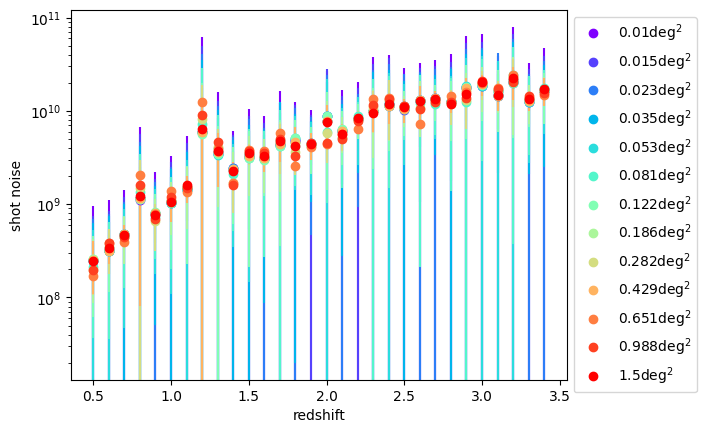

In [69]:
patchs = []
for tile_size, c in zip(field_size_list, cm.rainbow(np.linspace(0,1,len(field_size_list)))):
    if(fs<tile_size): continue
    patch = mlines.Line2D([], [], color=c, linestyle="None", marker='o', label=str(np.round(tile_size,3))+'$\\rm deg^2$'); patchs.append(patch);

    ragrid=np.arange(cat['ra'].min(),cat['ra'].max(),np.sqrt(tile_size))
    decgrid=np.arange(cat['dec'].min(),cat['dec'].max(),np.sqrt(tile_size))
    grid=np.array(np.meshgrid(ragrid,decgrid))

    ra_index = np.arange(0,len(ragrid)-1,1)
    dec_index = np.arange(0,len(decgrid)-1,1)
    ra_grid, dec_grid = np.meshgrid(ra_index, dec_index)
    # Flatten the grids and stack them into a single array
    coords = np.stack((ra_grid.flatten(), dec_grid.flatten()), axis=1)

    for i, (z, P_of_K,C) in enumerate(zip(z_list[::-1], P_of_K_matter_list, cm.rainbow(np.linspace(0,1,len(z_list[::-1]))))): 
        B_list = []

        cat_subfield = cat.loc[ (cat["redshift"] >= bin_edges[i]) & (cat["redshift"] < bin_edges[i+1]) ]

        for l, (ira, idec) in enumerate(coords):
            if l > 200: break 
            cat_subfield_z = cat_subfield.loc[(cat_subfield['ra']>=grid[0,idec,ira])&(cat_subfield['ra']<grid[0,idec,ira+1])&(cat_subfield['dec']>=grid[1,idec,ira])&(cat_subfield['dec']<grid[1,idec+1,ira])] 

            Dc_min = cosmo.comoving_distance(bin_edges[i])
            Dc_max = cosmo.comoving_distance(bin_edges[i+1])
            Dc =  cosmo.comoving_distance(z)/u.rad
            delta_Dc = ( (cst.c*1e-3*u.km/u.s) * (1+z) * Dnu[i] / cosmo.H(z) / nu_obs[i])
            pk_3d_to_2d = 1/(Dc**2*delta_Dc)
            k_3d_to_2d  = Dc/2/np.pi

            freq_obs = (freq_CII / (1 + cat_subfield_z['redshift']))
            vdelt = (cst.c * 1e-3) * Dnu[i] / freq_obs #km/s

            B_list.append( np.sum( (cat_subfield_z['ICII_de_Looze']/vdelt)**2) / (tile_size*u.deg**2).to(u.sr).value / pk_3d_to_2d.value )
        
        plt.errorbar(z, np.asarray(B_list).mean(), yerr=np.asarray(I_list).std(), fmt='o', color=c, ecolor=c)
plt.yscale('log')
plt.ylabel('shot noise')
plt.xlabel('redshift')
plt.legend(handles=patchs, bbox_to_anchor=(1,1))

In [2]:

dz_list = (0.1, 0.2, 0.3, 0.4 )
fig, axs = plt.subplots(1, len(dz_list), sharey=True, figsize=(8, 3.3), dpi = 200); lw=1.5

for j, (dz, ls) in enumerate(zip(dz_list, ('solid', ':', '--', '-.'))): 

    z_list = np.arange(0.5,3.5, dz/2)
    # Calculate the edges
    diffs = np.diff(z_list) / 2.0
    bin_edges = np.zeros(len(z_list) + 1)
    bin_edges[1:-1] = z_list[:-1] + diffs
    bin_edges[0] = z_list[0] - diffs[0]
    bin_edges[-1] = z_list[-1] + diffs[-1]
    #------
    nu_obs = freq_CII / (1+z_list)
    Dnu = dz * nu_obs / (1+z_list)
    K, P_of_K_matter_list =  get_2d_pk_matter(z_list)
    
    for i, (z, P_of_K,c) in enumerate(zip(z_list[::-1], P_of_K_matter_list, cm.rainbow(np.linspace(0,1,len(z_list[::-1]))))): 

        Dc_min = cosmo.comoving_distance(bin_edges[i])
        Dc_max = cosmo.comoving_distance(bin_edges[i+1])
        Dc =  cosmo.comoving_distance(z)/u.rad
        delta_Dc = ( (cst.c*1e-3*u.km/u.s) * (1+z) * Dnu[i] / cosmo.H(z) / nu_obs[i])
        pk_3d_to_2d = 1/(Dc**2*delta_Dc)
        k_3d_to_2d  = Dc/2/np.pi

        cat_galaxies = cat.loc[cat["Mstar"] >= 1e10]
        cat_galaxies = cat_galaxies.loc[cat["redshift"] >= bin_edges[i]]
        cat_galaxies = cat_galaxies.loc[cat["redshift"] < bin_edges[i+1]]
        shot_noise = 1 / (len(cat_galaxies) / (field_size_list[-1]*u.deg**2).to(u.sr)).value
        b = bias.haloBias(cat_galaxies["Mhalo"]/h, model = 'tinker10', z=z, mdef = '200m').mean()


        axs[j].loglog(K, P_of_K*b**2 + (shot_noise / pk_3d_to_2d).value, ls=ls, color=c)
        axs[j].set_ylim(1e2, 1e5)


NameError: name 'plt' is not defined